## 1. Import data
### Citation of paper providing original dataset:  M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145


In [ ]:
# Connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')

# content in your drive is now available via "/content/drive/My Drive"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import data and unzip files to folder
!unzip /content/drive/MyDrive/COVID-19_Radiography_Dataset.zip

In [ ]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3


In [ ]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

In [ ]:
#Reduce number of images to first 1345 for each category
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

In [ ]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img



#Try on single flower file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

In [ ]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [ ]:
len(image_filepaths)

4032

In [ ]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min().round() ) #min value of every image is zero
print(X.max() ) #max value of every image is one


4032
(4032, 192, 192, 3)
-0.0
1.0


In [ ]:
len(fnames[2])

1344

In [ ]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
4027,0,0,1
4028,0,0,1
4029,0,0,1
4030,0,0,1


## 2. Visualize images that demonstrate when x-rays demonstrate Covid Positivity and when they do not.

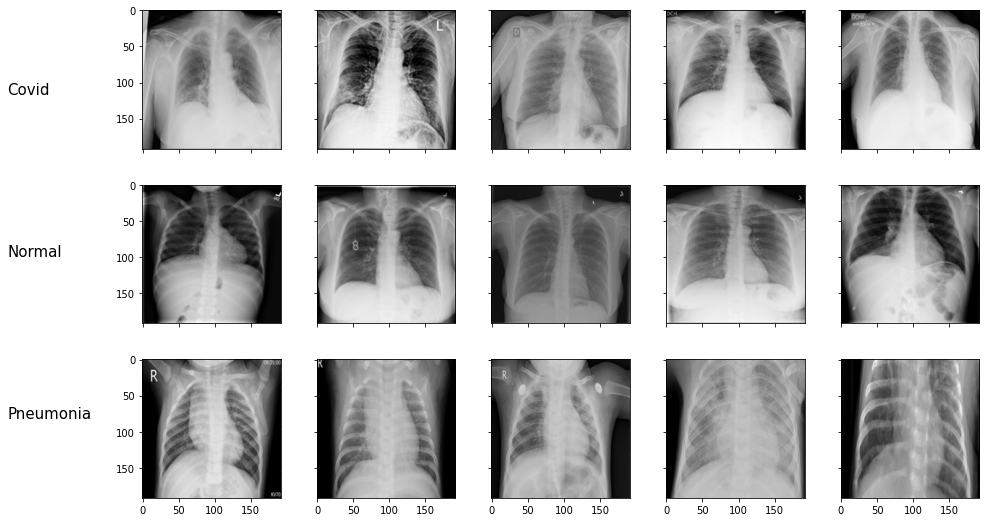

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random
from matplotlib.gridspec import SubplotSpec

# Covid images
im1 =preprocessor(fnames[0][10])
im2 =preprocessor(fnames[0][11])
im3 =preprocessor(fnames[0][12])
im4 =preprocessor(fnames[0][13])
im5 =preprocessor(fnames[0][14])
# Normal images
im6 =preprocessor(fnames[1][10])
im7 =preprocessor(fnames[1][11])
im8 =preprocessor(fnames[1][12])
im9 =preprocessor(fnames[1][13])
im10 =preprocessor(fnames[1][14])
# Pneumonia images
im11 =preprocessor(fnames[2][10])
im12 =preprocessor(fnames[2][11])
im13 =preprocessor(fnames[2][12])
im14 =preprocessor(fnames[2][13])
im15 =preprocessor(fnames[2][14])



fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 5),  # creates 3x5 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4, im5, im6, im7, im8, im9, im10, im11, im12, im13, im14, im15]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.figtext(0.00,0.65,'Covid',size=15)
plt.figtext(0.00,0.5,'Normal',size=15)
plt.figtext(0.00,0.35,'Pneumonia',size=15)
plt.show()

## 3. Train test split data

In [ ]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)


X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

In [ ]:
X_train.shape, y_train.shape

((2741, 192, 192, 3), (2741, 3))

In [ ]:
#Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [ ]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

#Save data
import pickle

# Open a file and use dump()
with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)

#Save data
import pickle

# Open a file and use dump()
with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)


# Open a file and use dump()
with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

In [ ]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

## 4. Discuss the dataset in general terms and describe why building a predictive model using this data might be practically useful.  Who could benefit from a model like this? Explain.

The dataset contains images for COVID-19 positive, normal, and viral pneumonia images. The Covid data are collected from different publicly accessible dataset, online sources and published paper including padchest dataset, a Germany medical school, SIRM, Github, Kaggle and Twitter, the normal images are collected from RSNA and Kaggle, and the viral pneumonia images are collected from the Chest X-Ray Images database.
We are using the first 1345 images for each category since there is a siginificant difference in terms of number of images within each category. The test size is 32% of the original data, stratify = y (proportional rate of each class in training & testing as the original dataset) and random state is set to 1987. The X_train shape equals to (2741, 192, 192, 3), y_train shape equals to (2741, 3), X_test shape is (1291, 192, 192, 3), and y_test shape is (1291, 3).

Building a predictive model using this data might be practically useful since machine learning algorithms are able to correctly identify patterns and characteristics that the human eye would overlook. This might speed up the diagnosing process. In the case of COVID-19 pneumonia, when fast detection is key for effective illness treatment, this can be particularly important.

Healthcare professionals might be benefit from the model since screening medical photographs can be labor and time-intensive. By automating the screening process, machine learning algorithms can lessen labor and free up healthcare workers to concentrate on other parts of patient care. Patients can also benefit as ML algorithms can assist to increase efficiency and accuracy, which can result in faster COVID-19 pneumonia detection and improved patient treatment results.

In general, the application of machine learning in COVID-19 and viral pneumonia screening has the potential to enhance diagnostic accuracy, speed, and efficiency, which can assist to enhance patient outcomes and lessen the burden on healthcare systems.

## 5. Run at least three prediction models to try to predict x-ray images well

### Model 1 Sequential

In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)  
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu',input_shape=(192, 192, 3)), 
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 10, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Epoch 1/10
69/69 [==============================] - 9s 107ms/step - loss: 0.8795 - accuracy: 0.5351 - val_loss: 0.6298 - val_accuracy: 0.7086
Epoch 2/10
69/69 [==============================] - 7s 100ms/step - loss: 0.6193 - accuracy: 0.7199 - val_loss: 0.6052 - val_accuracy: 0.7158
Epoch 3/10
69/69 [==============================] - 7s 99ms/step - loss: 0.4944 - accuracy: 0.7883 - val_loss: 0.4497 - val_accuracy: 0.8160
Epoch 4/10
69/69 [==============================] - 7s 97ms/step - loss: 0.3711 - accuracy: 0.8572 - val_loss: 0.4002 - val_accuracy: 0.8397
Epoch 5/10
69/69 [==============================] - 7s 99ms/step - loss: 0.3443 - accuracy: 0.8677 - val_loss: 0.3992 - val_accuracy: 0.8579
Epoch 6/10
69/69 [==============================] - 7s 96ms/step - loss: 0.2793 - accuracy: 0.8937 - val_loss: 0.2956 - val_accuracy: 0.8962
Epoch 7/10
69/69 [==============================] - 7s 98ms/step - loss: 0.2332 - accuracy: 0.9165 - val_loss: 0.2782 - val_accuracy: 0.8980
Epoch 8/10


In [ ]:
model.save("model1.h5", save_format="h5")

In [ ]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model1.h5',compile=False)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        4160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                    

In [ ]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7f471b1ff1f0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 2s 29ms/step


In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 7

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,averagepooling2d_layers,conv2d_layers,batchnormalization_layers,dense_layers,maxpooling2d_layers,inputlayer_layers,flatten_layers,concatenate_layers,relu_act,softmax_act,loss,optimizer,memory_size,username,version
0,89.08%,89.19%,89.69%,89.08%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,francesyang,7
1,88.69%,88.46%,88.93%,88.68%,keras,True,True,Functional,220.000000,25473251.000000,9.000000,94.000000,94.000000,2.000000,4.000000,1.000000,1.000000,15.000000,95.000000,1.000000,str,Adam,101943424.000000,francesyang,8
2,72.42%,72.36%,72.31%,72.41%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,newusertest,2
3,72.42%,72.36%,72.31%,72.41%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,newusertest,3
4,72.19%,70.99%,73.62%,72.17%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,mikedparrott,1
5,33.77%,33.78%,33.79%,33.77%,keras,nan,True,Sequential,14.000000,1189155.000000,nan,8.000000,nan,1.000000,4.000000,nan,1.000000,nan,8.000000,1.000000,str,Adam,4759312.000000,emileesmaili,4
6,33.77%,33.78%,33.79%,33.77%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,emileesmaili,5
7,33.00%,32.99%,32.99%,33.00%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,emileesmaili,6


In [ ]:
#Submit Model with predictions only (if you cannot save an onnx file): 

#-- Generate predicted y values (Model 1)
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = None,
                                 preprocessor_filepath=None,
                                 prediction_submission=prediction_labels)

### Model 2 using InceptionV3

In [ ]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition

base_model.summary()


87910968/87910968 [==============================] - 5s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 95, 95, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d_10[0][0]']              
 alization)                                                                                       
                      

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune everything up to this layer onwards
freeze_layers_after=10

# Freeze all the layers after the `freeze_layers_after` layer
for layer in base_model.layers[freeze_layers_after:]:
  layer.trainable =  False

print("Number of layers frozen in the base model: ", len(base_model.layers)-freeze_layers_after)


Number of layers in the base model:  311
Number of layers frozen in the base model:  301


In [ ]:
from keras.layers import GlobalAveragePooling2D
import tensorflow as tf
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 95, 95, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d_10[0][0]']              
 alization)                                                                                       
                                                                                              

In [ ]:
# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(112, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)

# define new model
model = Model(inputs=base_model.inputs, outputs=output) #base_model.inputs imports the vgg16 model defined in base_model

# summarize
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 95, 95, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d_10[0][0]']              
 alization)                                                                                       
                                                                                            

In [ ]:
# Fit Inception model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 10, verbose=1,validation_split=.2)

Epoch 1/10
69/69 [==============================] - 29s 227ms/step - loss: 3.3988 - acc: 0.7605 - val_loss: 1.4046 - val_acc: 0.7286
Epoch 2/10
69/69 [==============================] - 10s 152ms/step - loss: 0.4287 - acc: 0.8805 - val_loss: 1.5330 - val_acc: 0.7341
Epoch 3/10
69/69 [==============================] - 11s 158ms/step - loss: 0.2390 - acc: 0.9220 - val_loss: 0.6067 - val_acc: 0.8452
Epoch 4/10
69/69 [==============================] - 11s 155ms/step - loss: 0.2282 - acc: 0.9302 - val_loss: 0.8199 - val_acc: 0.8124
Epoch 5/10
69/69 [==============================] - 11s 153ms/step - loss: 0.1192 - acc: 0.9630 - val_loss: 0.8800 - val_acc: 0.8251
Epoch 6/10
69/69 [==============================] - 11s 156ms/step - loss: 0.0960 - acc: 0.9658 - val_loss: 0.4908 - val_acc: 0.8652
Epoch 7/10
69/69 [==============================] - 10s 152ms/step - loss: 0.0514 - acc: 0.9813 - val_loss: 0.6540 - val_acc: 0.8634
Epoch 8/10
69/69 [==============================] - 11s 153ms/step - 

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7f46f78138b0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 5s 62ms/step


In [ ]:
# Submit Model 2 to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 8

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,averagepooling2d_layers,conv2d_layers,batchnormalization_layers,dense_layers,maxpooling2d_layers,inputlayer_layers,flatten_layers,concatenate_layers,relu_act,softmax_act,loss,optimizer,memory_size,username,version
0,89.08%,89.19%,89.69%,89.08%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,francesyang,7
1,88.69%,88.46%,88.93%,88.68%,keras,True,True,Functional,220.000000,25473251.000000,9.000000,94.000000,94.000000,2.000000,4.000000,1.000000,1.000000,15.000000,95.000000,1.000000,str,Adam,101943424.000000,francesyang,8
2,72.42%,72.36%,72.31%,72.41%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,newusertest,2
3,72.42%,72.36%,72.31%,72.41%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,newusertest,3
4,72.19%,70.99%,73.62%,72.17%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,mikedparrott,1
5,33.77%,33.78%,33.79%,33.77%,keras,nan,True,Sequential,14.000000,1189155.000000,nan,8.000000,nan,1.000000,4.000000,nan,1.000000,nan,8.000000,1.000000,str,Adam,4759312.000000,emileesmaili,4
6,33.77%,33.78%,33.79%,33.77%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,emileesmaili,5
7,33.00%,32.99%,32.99%,33.00%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,emileesmaili,6


### Model 3 using InceptionResNetV2

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
base_model = InceptionResNetV2(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition
base_model.summary()


Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 95, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune everything up to this layer onwards
freeze_layers_after=50

# Freeze all the layers after the `freeze_layers_after` layer
for layer in base_model.layers[freeze_layers_after:]:
  layer.trainable =  False

print("Number of layers frozen in the base model: ", len(base_model.layers)-freeze_layers_after)

Number of layers in the base model:  780
Number of layers frozen in the base model:  730


In [ ]:
from keras.layers import GlobalAveragePooling2D
import tensorflow as tf
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 95, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [ ]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 10, verbose=1,validation_split=.2)

Epoch 1/10
69/69 [==============================] - 41s 394ms/step - loss: 0.2792 - acc: 0.8846 - val_loss: 0.3261 - val_acc: 0.8871
Epoch 2/10
69/69 [==============================] - 23s 335ms/step - loss: 0.0615 - acc: 0.9831 - val_loss: 0.3267 - val_acc: 0.8998
Epoch 3/10
69/69 [==============================] - 23s 334ms/step - loss: 0.0218 - acc: 0.9964 - val_loss: 0.5020 - val_acc: 0.8743
Epoch 4/10
69/69 [==============================] - 23s 334ms/step - loss: 0.0538 - acc: 0.9808 - val_loss: 0.2771 - val_acc: 0.8998
Epoch 5/10
69/69 [==============================] - 23s 332ms/step - loss: 0.0208 - acc: 0.9941 - val_loss: 0.4343 - val_acc: 0.8889
Epoch 6/10
69/69 [==============================] - 23s 336ms/step - loss: 0.0134 - acc: 0.9964 - val_loss: 0.2287 - val_acc: 0.9362
Epoch 7/10
69/69 [==============================] - 23s 330ms/step - loss: 0.0122 - acc: 0.9977 - val_loss: 0.2678 - val_acc: 0.9417
Epoch 8/10
69/69 [==============================] - 23s 333ms/step - 

In [ ]:
#Submit Model with predictions only (if you cannot save an onnx file): 

#-- Generate predicted y values (Model 3)
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 3 to Competition Leaderboard
experiment.submit_model(model_filepath = None,
                                 preprocessor_filepath=None,
                                 prediction_submission=prediction_labels)

41/41 [==============================] - 10s 129ms/step
Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 9

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,averagepooling2d_layers,conv2d_layers,batchnormalization_layers,dense_layers,maxpooling2d_layers,inputlayer_layers,add_layers,globalaveragepooling2d_layers,zeropadding2d_layers,flatten_layers,concatenate_layers,relu_act,softmax_act,loss,optimizer,memory_size,team,username,version
0,95.58%,95.59%,95.60%,95.58%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,9
1,91.71%,91.66%,91.68%,91.71%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,nan,hal2148,14
2,91.09%,91.10%,91.16%,91.09%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,6.000000,bobbie8881,10
3,89.16%,89.18%,89.79%,89.15%,keras,nan,True,Sequential,16.000000,56995.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,231216.000000,nan,sofiazaidman,11
4,89.08%,89.19%,89.69%,89.08%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,nan,francesyang,7
5,88.69%,88.46%,88.93%,88.68%,keras,True,True,Functional,220.000000,25473251.000000,9.000000,94.000000,94.000000,2.000000,4.000000,1.000000,nan,nan,nan,1.000000,15.000000,95.000000,1.000000,str,Adam,101943424.000000,nan,francesyang,8
6,87.68%,87.60%,87.63%,87.68%,keras,True,True,Functional,219.000000,21808931.000000,9.000000,94.000000,94.000000,1.000000,4.000000,1.000000,nan,1.000000,nan,nan,15.000000,94.000000,1.000000,str,Adam,87285904.000000,nan,hal2148,17
7,85.75%,85.58%,85.74%,85.74%,keras,nan,True,Sequential,6.000000,7090627.000000,nan,nan,nan,5.000000,nan,nan,nan,nan,nan,1.000000,nan,4.000000,1.000000,str,SGD,28363912.000000,nan,hal2148,13
8,85.21%,84.95%,85.93%,85.20%,keras,True,True,Functional,219.000000,21808931.000000,9.000000,94.000000,94.000000,1.000000,4.000000,1.000000,nan,1.000000,nan,nan,15.000000,94.000000,1.000000,str,Adam,87285904.000000,nan,sofiazaidman,12
9,83.19%,83.15%,83.62%,83.18%,keras,True,True,Functional,21.000000,14716227.000000,nan,13.000000,nan,1.000000,5.000000,1.000000,nan,1.000000,nan,nan,nan,13.000000,1.000000,str,Adam,58869040.000000,nan,hal2148,16


### Discuss which models performed better and point out relevant hyper-parameter values for successful models.

All 3 models performed fairly well with accuracy of 89.08% (sequential), 88.69% (InceptionV3) and 95.58%(InceptionResNetV2). The model with the highest accuracy and f1 score is InceptionResNetV2 with accuracy 95.58% and F1 score 95.59%.
InceptionResNetV2 is a combination of the advanced Inception and ResNet models, which excel in their respective domains. By utilizing convolutional layers with varying filter sizes, it can efficiently extract features from input images, capturing fine-grained details with smaller filters and broad patterns with larger ones. Furthermore, it employs dropout and batch normalization methods to diminish overfitting, preventing the network from exclusively memorizing the training data and enhancing its capacity to generalize to new, unseen data. There were 54,341,347 total parameters with 189,235 trainable parameters in my InceptionResNetV2 model, and I did freeze 730 layers (freeze_layers_after=50, 780 layers in total) with 10 epochs to better fit this particular dataset.

### 6. After you submit your first three models, describe your best model with your team via your team slack channel

### Fit and submit up to three more models after learning from your team.
### Model 4 (InceptionResNetV2 with 20 trainable layers)

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
base_model = InceptionResNetV2(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_231 (Conv2D)            (None, 95, 95, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_203 (Batch  (None, 95, 95, 32)  96          ['conv2d_231[0][0]']             
 Normalization)                                                                                   
                                                                                

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune everything up to this layer onwards
freeze_layers_after=20

# Freeze all the layers after the `freeze_layers_after` layer
for layer in base_model.layers[freeze_layers_after:]:
  layer.trainable =  False

print("Number of layers frozen in the base model: ", len(base_model.layers)-freeze_layers_after)

Number of layers in the base model:  780
Number of layers frozen in the base model:  760


In [ ]:
from keras.layers import GlobalAveragePooling2D
import tensorflow as tf
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_231 (Conv2D)            (None, 95, 95, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_203 (Batch  (None, 95, 95, 32)  96          ['conv2d_231[0][0]']             
 Normalization)                                                                                   
                                                                                            

In [ ]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 10, verbose=1,validation_split=.2)

Epoch 1/10
69/69 [==============================] - 45s 416ms/step - loss: 0.5429 - acc: 0.7564 - val_loss: 0.6584 - val_acc: 0.7450
Epoch 2/10
69/69 [==============================] - 22s 324ms/step - loss: 0.2131 - acc: 0.9183 - val_loss: 0.8580 - val_acc: 0.6594
Epoch 3/10
69/69 [==============================] - 23s 328ms/step - loss: 0.1794 - acc: 0.9279 - val_loss: 0.7493 - val_acc: 0.7195
Epoch 4/10
69/69 [==============================] - 23s 331ms/step - loss: 0.0809 - acc: 0.9717 - val_loss: 0.6110 - val_acc: 0.7887
Epoch 5/10
69/69 [==============================] - 23s 333ms/step - loss: 0.0439 - acc: 0.9863 - val_loss: 0.3551 - val_acc: 0.9089
Epoch 6/10
69/69 [==============================] - 23s 334ms/step - loss: 0.0182 - acc: 0.9973 - val_loss: 0.4382 - val_acc: 0.8761
Epoch 7/10
69/69 [==============================] - 23s 334ms/step - loss: 0.0119 - acc: 0.9991 - val_loss: 0.3529 - val_acc: 0.9053
Epoch 8/10
69/69 [==============================] - 23s 334ms/step - 

In [ ]:
#Submit Model with predictions only (if you cannot save an onnx file): 

#-- Generate predicted y values (Model 4)
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 4 to Competition Leaderboard
experiment.submit_model(model_filepath = None,
                                 preprocessor_filepath=None,
                                 prediction_submission=prediction_labels)

### Model 5 (EfficientNetB7)

In [ ]:
from tensorflow.keras.applications import VGG19
base_model = VGG19(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition
base_model.summary()

80134624/80134624 [==============================] - 4s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                              

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune everything up to this layer onwards
freeze_layers_after=5

# Freeze all the layers after the `freeze_layers_after` layer
for layer in base_model.layers[freeze_layers_after:]:
  layer.trainable =  False

print("Number of layers frozen in the base model: ", len(base_model.layers)-freeze_layers_after)

Number of layers in the base model:  22
Number of layers frozen in the base model:  17


In [ ]:
from keras.layers import GlobalAveragePooling2D
import tensorflow as tf
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)

In [ ]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 10, verbose=1,validation_split=.2)

Epoch 1/10
69/69 [==============================] - 32s 384ms/step - loss: 0.8662 - acc: 0.6113 - val_loss: 0.6372 - val_acc: 0.7523
Epoch 2/10
69/69 [==============================] - 23s 327ms/step - loss: 0.5564 - acc: 0.7600 - val_loss: 0.5014 - val_acc: 0.7760
Epoch 3/10
69/69 [==============================] - 23s 333ms/step - loss: 0.4600 - acc: 0.7956 - val_loss: 0.4729 - val_acc: 0.8051
Epoch 4/10
69/69 [==============================] - 23s 335ms/step - loss: 0.4107 - acc: 0.8111 - val_loss: 0.4495 - val_acc: 0.8179
Epoch 5/10
69/69 [==============================] - 23s 339ms/step - loss: 0.3980 - acc: 0.8257 - val_loss: 0.3995 - val_acc: 0.8160
Epoch 6/10
69/69 [==============================] - 24s 342ms/step - loss: 0.3605 - acc: 0.8362 - val_loss: 0.3901 - val_acc: 0.8470
Epoch 7/10
69/69 [==============================] - 23s 340ms/step - loss: 0.3357 - acc: 0.8577 - val_loss: 0.4048 - val_acc: 0.8397
Epoch 8/10
69/69 [==============================] - 23s 339ms/step - 

In [ ]:
#Submit Model with predictions only (if you cannot save an onnx file): 

#-- Generate predicted y values (Model 5)
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 5 to Competition Leaderboard
experiment.submit_model(model_filepath = None,
                                 preprocessor_filepath=None,
                                 prediction_submission=prediction_labels)

### Model 6 (InceptionResNetV2, 50 trainable layers with SGD optimizer)

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
base_model = InceptionResNetV2(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune everything up to this layer onwards
freeze_layers_after=50

# Freeze all the layers after the `freeze_layers_after` layer
for layer in base_model.layers[freeze_layers_after:]:
  layer.trainable =  False

print("Number of layers frozen in the base model: ", len(base_model.layers)-freeze_layers_after)

Number of layers in the base model:  780
Number of layers frozen in the base model:  730


In [ ]:
from keras.layers import GlobalAveragePooling2D
import tensorflow as tf
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 95, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 95, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [ ]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 10, verbose=1,validation_split=.2)

Epoch 1/10
69/69 [==============================] - 45s 400ms/step - loss: 0.0016 - acc: 0.9995 - val_loss: 0.1162 - val_acc: 0.9690
Epoch 2/10
69/69 [==============================] - 23s 332ms/step - loss: 6.6896e-04 - acc: 1.0000 - val_loss: 0.1175 - val_acc: 0.9672
Epoch 3/10
69/69 [==============================] - 23s 331ms/step - loss: 6.5037e-04 - acc: 1.0000 - val_loss: 0.1163 - val_acc: 0.9690
Epoch 4/10
69/69 [==============================] - 23s 341ms/step - loss: 4.8737e-04 - acc: 1.0000 - val_loss: 0.1170 - val_acc: 0.9690
Epoch 5/10
69/69 [==============================] - 25s 357ms/step - loss: 4.2713e-04 - acc: 1.0000 - val_loss: 0.1174 - val_acc: 0.9672
Epoch 6/10
69/69 [==============================] - 23s 339ms/step - loss: 3.3255e-04 - acc: 1.0000 - val_loss: 0.1181 - val_acc: 0.9654
Epoch 7/10
69/69 [==============================] - 23s 333ms/step - loss: 3.1182e-04 - acc: 1.0000 - val_loss: 0.1187 - val_acc: 0.9654
Epoch 8/10
69/69 [===========================

In [ ]:
#Submit Model with predictions only (if you cannot save an onnx file): 

#-- Generate predicted y values (Model 6)
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 6 to Competition Leaderboard
experiment.submit_model(model_filepath = None,
                                 preprocessor_filepath=None,
                                 prediction_submission=prediction_labels)

41/41 [==============================] - 11s 128ms/step
Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 23

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,averagepooling2d_layers,conv2d_layers,batchnormalization_layers,dense_layers,maxpooling2d_layers,inputlayer_layers,add_layers,globalaveragepooling2d_layers,zeropadding2d_layers,flatten_layers,concatenate_layers,relu_act,softmax_act,loss,optimizer,memory_size,team,username,version
0,96.36%,96.37%,96.38%,96.36%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,23
1,96.28%,96.27%,96.30%,96.28%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,22
2,95.82%,95.82%,95.88%,95.82%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,20
3,95.58%,95.59%,95.60%,95.58%,unknown,nan,nan,unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,francesyang,9
4,93.73%,93.71%,93.71%,93.72%,keras,True,True,Functional,219.000000,21808931.000000,9.000000,94.000000,94.000000,1.000000,4.000000,1.000000,nan,1.000000,nan,nan,15.000000,94.000000,1.000000,str,Adam,87285904.000000,nan,hal2148,18
5,91.71%,91.66%,91.68%,91.71%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,nan,hal2148,14
6,91.09%,91.10%,91.16%,91.09%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,6.000000,bobbie8881,10
7,90.86%,90.90%,90.98%,90.86%,keras,True,True,Functional,219.000000,21808931.000000,9.000000,94.000000,94.000000,1.000000,4.000000,1.000000,nan,1.000000,nan,nan,15.000000,94.000000,1.000000,str,Adam,87285904.000000,nan,hal2148,19
8,89.16%,89.18%,89.79%,89.15%,keras,nan,True,Sequential,16.000000,56995.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,231216.000000,nan,sofiazaidman,11
9,89.08%,89.19%,89.69%,89.08%,keras,nan,True,Sequential,16.000000,3811619.000000,nan,10.000000,nan,1.000000,4.000000,nan,nan,nan,nan,1.000000,nan,10.000000,1.000000,str,Adam,15249712.000000,nan,francesyang,7


### Discuss result

After discussion with my team members I realized maybe I should try different numbers of trainable layers and different optimizer. So I tried InceptionResNetV2 with 20 trainable layers and adam optimizer, EfficientNetB7, and InceptionResNetV2 with 50 trainable layers and SGD optimizer. The final results for all 3 are not bad and model 6 has the highest accuracy (96.36%) and F1 score (96.37%). Even though I was unable to save those models locally to an onnx file cause of the file size but I was still able to upload the prediction labels to aimodelshare.

### 7. Try to use augmented data to rerun at least one model and submit it to the leaderboard

### Data augmentation layer

In [ ]:
data_augmentation_layer = tf.keras.Sequential([                                    
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2)                             
])

### Apply data augmentation

In [ ]:
  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)  
    data_augmentation_layer,
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu',input_shape=(192, 192, 3)), 
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 10, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Epoch 1/10
69/69 [==============================] - 11s 138ms/step - loss: 0.9609 - accuracy: 0.5114 - val_loss: 0.7654 - val_accuracy: 0.6721
Epoch 2/10
69/69 [==============================] - 10s 144ms/step - loss: 0.7885 - accuracy: 0.6209 - val_loss: 0.7563 - val_accuracy: 0.6630
Epoch 3/10
69/69 [==============================] - 8s 122ms/step - loss: 0.7429 - accuracy: 0.6501 - val_loss: 0.6779 - val_accuracy: 0.7067
Epoch 4/10
69/69 [==============================] - 13s 184ms/step - loss: 0.7242 - accuracy: 0.6606 - val_loss: 0.6400 - val_accuracy: 0.7177
Epoch 5/10
69/69 [==============================] - 9s 125ms/step - loss: 0.7179 - accuracy: 0.6679 - val_loss: 0.6851 - val_accuracy: 0.6995
Epoch 6/10
69/69 [==============================] - 10s 143ms/step - loss: 0.6891 - accuracy: 0.6911 - val_loss: 0.6141 - val_accuracy: 0.7231
Epoch 7/10
69/69 [==============================] - 9s 131ms/step - loss: 0.7009 - accuracy: 0.6638 - val_loss: 0.6135 - val_accuracy: 0.7250
Ep

In [ ]:
#Submit Model with predictions only (if you cannot save an onnx file): 

#-- Generate predicted y values (Model 7)
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 7 to Competition Leaderboard
experiment.submit_model(model_filepath = None,
                                 preprocessor_filepath=None,
                                 prediction_submission=prediction_labels)

### Discuss results

The sequential model's accuracy with testing dataset actually lowered quite a bit after data augmentation (from 89.08% to 72.30%). Data augmentation techniques may not be suitable for a particular problem and dataset, leading to inappropriate augmentation. For instance, the data augmentation techniques applied to the images may lead to excessive distortion, the model may struggle to accurately identify the objects in the images. Alternatively, low-quality augmented data can negatively affect the model's performance, such as when the images generated are blurry or contain a high level of noise. In such cases, the model may find it challenging to recognize the objects in the images accurately.

## 8.Discuss which models you tried and which models performed better and point out relevant hyper-parameter values for successful models.

I've tried 7 different models so far and the highest performing model is  InceptionResNetV2 with 50 trainable layers and SGD optimizer with the highest accuracy (96.36%) and F1 score (96.37%). 
The InceptionResNetV2 architecture is trained on extensive datasets, including ImageNet, which gives the network a robust base to learn features. This pre-training on large datasets also helps to prevent the problem of overfitting and enables the network to generalize effectively to new datasets and batch normalization is utilized, which aids in mitigating the impact of covariate shift while training. By stabilizing the distribution of activations in every layer of the network, batch normalization contributes to quicker training and improved performance. 
Trying out different optimizer also helped, Adam optimizer is known for its fast convergence to the minimum of the loss function, but it may not always lead to the global minimum. Sometimes, using SGD optimizer with an appropriate learning rate can result in faster convergence to the global minimum. When fine-tuning a pre-trained model, SGD optimizer can be more effective than Adam optimizer because pre-trained models often have important features that could be forgotten if the optimization process is too fast using Adam optimizer.

## 9. Link to Github
https://github.com/franyang6/Covid_Hackathon